## Importing libraries

In [104]:
!pip install xgboost
!pip install scikit-optimize

In [105]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## XGBoost implementation

### Preparing the Dataset

In [107]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

In [108]:
# adding features that make more sense than raw data
all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

for lag in range(1, 4):
  all_prices[f"Gold_lag_{lag}"] = all_prices["Gold"].shift(lag)
  all_prices[f"Silver_lag_{lag}"] = all_prices["Silver"].shift(lag)
  all_prices[f"CAD_lag_{lag}"] = all_prices["CAD"].shift(lag)

In [109]:
# price to predict, the price of the next timestep
all_prices["Gold_target"] = all_prices["Gold"].shift(-1)
all_prices["Silver_target"] = all_prices["Silver"].shift(-1)
all_prices["CAD_target"] = all_prices["CAD"].shift(-1)

In [110]:
all_prices = all_prices.dropna()

In [111]:
all_prices.head()

,Datetime,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
4,2025-09-09 01:00:00+00:00,3726.300049,43.514999,0.724071,0.0,0.0,-0.000492,3726.300049,43.514999,0.724597,...,0.724428,3726.300049,43.514999,0.724743,3726.300049,43.514999,0.724879,3726.300049,43.514999,0.724475
5,2025-09-09 01:30:00+00:00,3726.300049,43.514999,0.724475,0.0,0.0,0.000558,3726.300049,43.514999,0.724519,...,0.724071,3726.300049,43.514999,0.724428,3726.300049,43.514999,0.724743,3726.300049,43.514999,0.724638
6,2025-09-09 02:00:00+00:00,3726.300049,43.514999,0.724638,0.0,0.0,0.000225,3726.300049,43.514999,0.724471,...,0.724475,3726.300049,43.514999,0.724071,3726.300049,43.514999,0.724428,3726.300049,43.514999,0.724533
7,2025-09-09 02:30:00+00:00,3726.300049,43.514999,0.724533,0.0,0.0,-0.000145,3726.300049,43.514999,0.724429,...,0.724638,3726.300049,43.514999,0.724475,3726.300049,43.514999,0.724071,3726.300049,43.514999,0.724255
8,2025-09-09 03:00:00+00:00,3726.300049,43.514999,0.724255,0.0,0.0,-0.000384,3726.300049,43.514999,0.724394,...,0.724533,3726.300049,43.514999,0.724638,3726.300049,43.514999,0.724475,3726.300049,43.514999,0.724144


In [112]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2814 entries, 4 to 2817
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       2814 non-null   object 
 1   Gold           2814 non-null   float64
 2   Silver         2814 non-null   float64
 3   CAD            2814 non-null   float64
 4   Gold_ret       2814 non-null   float64
 5   Silver_ret     2814 non-null   float64
 6   CAD_ret        2814 non-null   float64
 7   Gold_ma        2814 non-null   float64
 8   Silver_ma      2814 non-null   float64
 9   CAD_ma         2814 non-null   float64
 10  Gold_lag_1     2814 non-null   float64
 11  Silver_lag_1   2814 non-null   float64
 12  CAD_lag_1      2814 non-null   float64
 13  Gold_lag_2     2814 non-null   float64
 14  Silver_lag_2   2814 non-null   float64
 15  CAD_lag_2      2814 non-null   float64
 16  Gold_lag_3     2814 non-null   float64
 17  Silver_lag_3   2814 non-null   float64
 18  CAD_lag_3    

In [113]:
all_prices.describe()

,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_lag_1,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
count,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,...,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000
mean,3996.416996,48.202537,0.715725,0.000049,0.000102,-0.000004,3996.043791,48.192896,0.715731,3996.230393,...,0.715728,3996.043791,48.192896,0.715731,3995.857188,48.188075,0.715734,3996.603599,48.207357,0.715722
std,172.562411,3.021660,0.004866,0.002052,0.003403,0.000373,172.418594,3.011077,0.004866,172.570495,...,0.004868,172.578378,3.014951,0.004871,172.586058,3.011579,0.004874,172.554124,3.024998,0.004863
min,3721.399902,43.514999,0.707269,-0.014739,-0.039054,-0.002440,3724.160010,43.514999,0.707599,3721.399902,...,0.707269,3721.399902,43.514999,0.707269,3721.399902,43.514999,0.707269,3721.399902,43.514999,0.707269
25%,3855.749939,46.641250,0.712419,-0.000601,-0.001035,-0.000201,3856.184985,46.635501,0.712408,3855.250061,...,0.712419,3854.574951,46.632501,0.712419,3853.499939,46.626250,0.712419,3856.199951,46.646251,0.712419
50%,4016.650024,48.197500,0.714457,0.000000,0.000000,-0.000007,4016.100000,48.201000,0.714444,4016.500000,...,0.714457,4016.349976,48.195000,0.714457,4016.250000,48.195000,0.714457,4016.750000,48.200001,0.714457
75%,4125.299805,50.568749,0.718128,0.000877,0.001458,0.000194,4126.230103,50.574750,0.718192,4125.174805,...,0.718132,4124.799805,50.563749,0.718152,4124.799805,50.560001,0.718163,4125.374878,50.570000,0.718121
max,4394.299805,57.080002,0.728014,0.014620,0.045237,0.002382,4383.499902,57.080002,0.727883,4394.299805,...,0.728014,4394.299805,57.080002,0.728014,4394.299805,57.080002,0.728014,4394.299805,57.080002,0.728014


In [114]:
X = all_prices.drop(columns=["Datetime", 'Gold_target', 'Silver_target', 'CAD_target'])
y = all_prices[['Gold_target', 'Silver_target', 'CAD_target']]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

### XGBoost experimenting

In [116]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [117]:
num_round = 15
param = {
    'learning_rate': 0.5,
    'max_depth': 30,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-rmse:51.60134	eval-rmse:47.27487


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-rmse:26.34883	eval-rmse:26.58322
[2]	train-rmse:13.74820	eval-rmse:18.69247
[3]	train-rmse:7.52534	eval-rmse:16.88443
[4]	train-rmse:4.35651	eval-rmse:15.46969
[5]	train-rmse:2.61036	eval-rmse:14.96805
[6]	train-rmse:1.63329	eval-rmse:14.55467
[7]	train-rmse:1.06149	eval-rmse:14.34496
[8]	train-rmse:0.70949	eval-rmse:14.16792
[9]	train-rmse:0.48613	eval-rmse:14.09569
[10]	train-rmse:0.34037	eval-rmse:13.99929
[11]	train-rmse:0.23812	eval-rmse:13.93979
[12]	train-rmse:0.17009	eval-rmse:13.90479
[13]	train-rmse:0.12238	eval-rmse:13.88385
[14]	train-rmse:0.08899	eval-rmse:13.87187


In [118]:
ypred = bst.predict(dtest)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

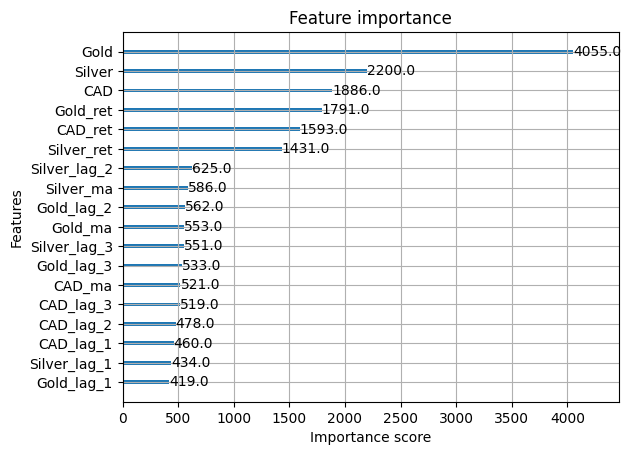

In [119]:
xgb.plot_importance(bst)

In [120]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [121]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [122]:
gold_pred = ypred[:, 0]
silver_pred = ypred[:, 1]
cad_pred = ypred[:, 2]

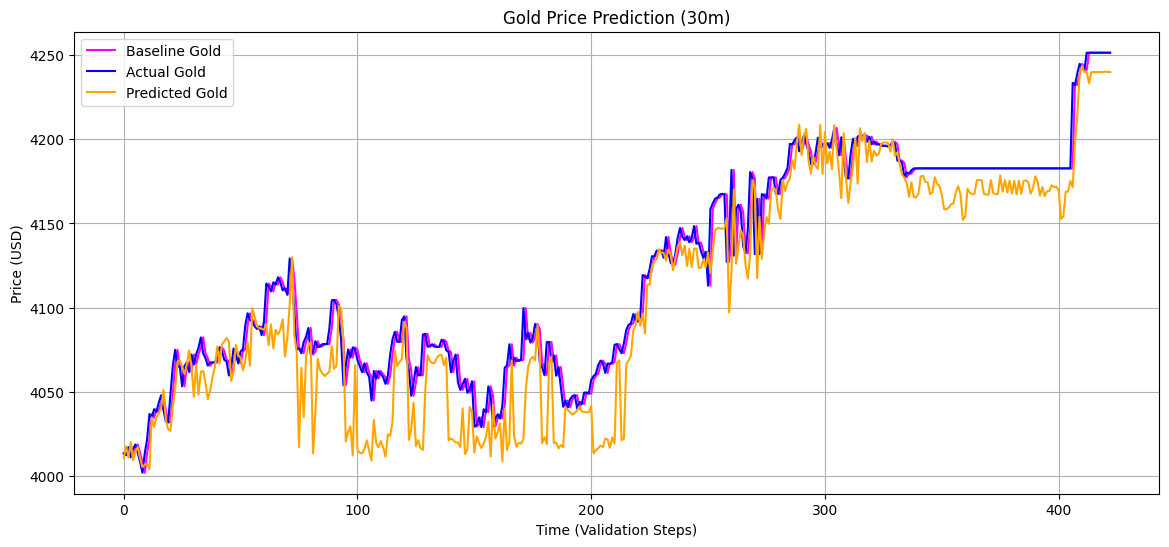

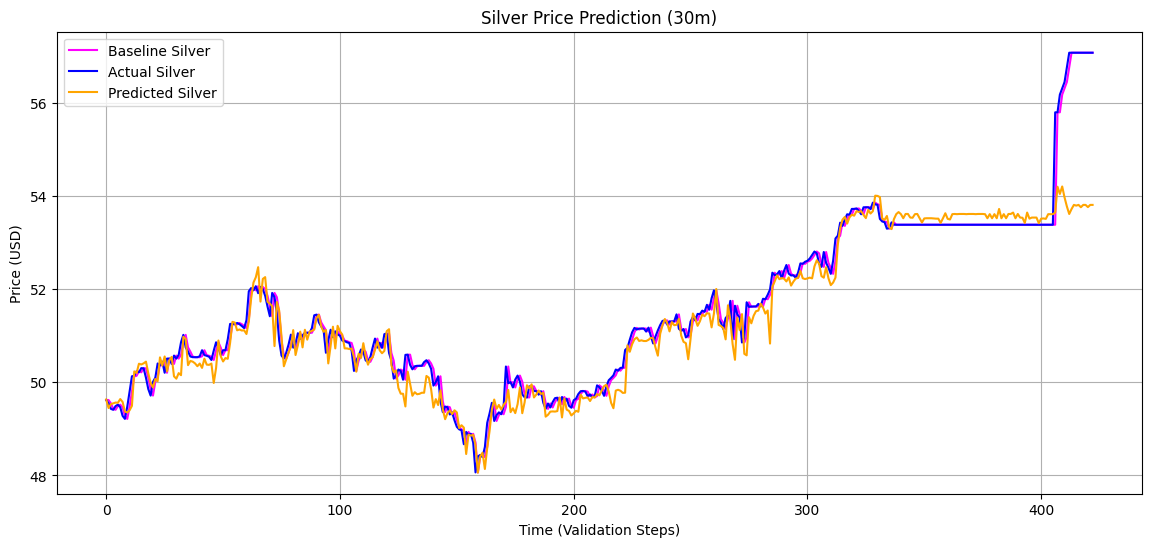

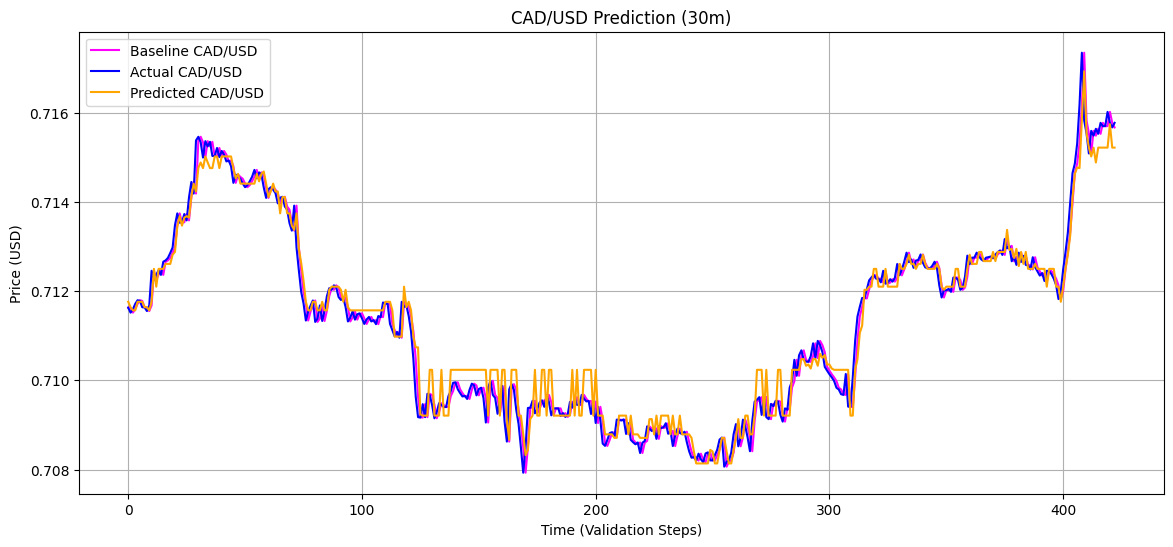

In [123]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [134]:
search_space = {
    'max_depth': Integer(2, 20),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'n_estimators': Integer (5, 30),
    'eval_metric': ['rmse', 'mae', 'mape']
}

In [135]:
n_train = int(len(X_train) * 0.70)
n_val = int(len(X_train) * 0.15)

train_indices = np.full(n_train, -1)
val_indices = np.zeros(n_val)

test_fold = np.concatenate([train_indices, val_indices])
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

In [136]:
opt = BayesSearchCV(
    XGBRegressor(tree_method="auto"),
    search_space,
    n_iter=50,
    cv=ps,
    scoring='neg_mean_absolute_error'
)

In [137]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,...
                                     n_jobs=None, num_parallel_tree=None, ...),
              scoring='neg_mean_absolute_error',
              search_spaces={'eval_metric': ['rmse', 'mae', 'mape'],
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=30, prior='uniform', transform='normalize')})

### Metrics Evaluation

In [138]:
best_params = opt.best_params_
best_params

OrderedDict([('eval_metric', 'rmse'),
             ('learning_rate', 0.14861155824274536),
             ('max_depth', 4),
             ('n_estimators', 30)])

In [139]:
best_model = opt.best_estimator_
predictions = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print('Mean Absolute Error :', mae)
print('Root Mean Squared Error :', rmse)
print('Mean Absolute Percentage Error :', mape)

Mean Absolute Error : 2.3256068229675293
Root Mean Squared Error : 5.959851407240513
Mean Absolute Percentage Error : 0.002307318849489093


In [140]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [141]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [142]:
gold_pred = ypred[:, 0]
silver_pred = ypred[:, 1]
cad_pred = ypred[:, 2]

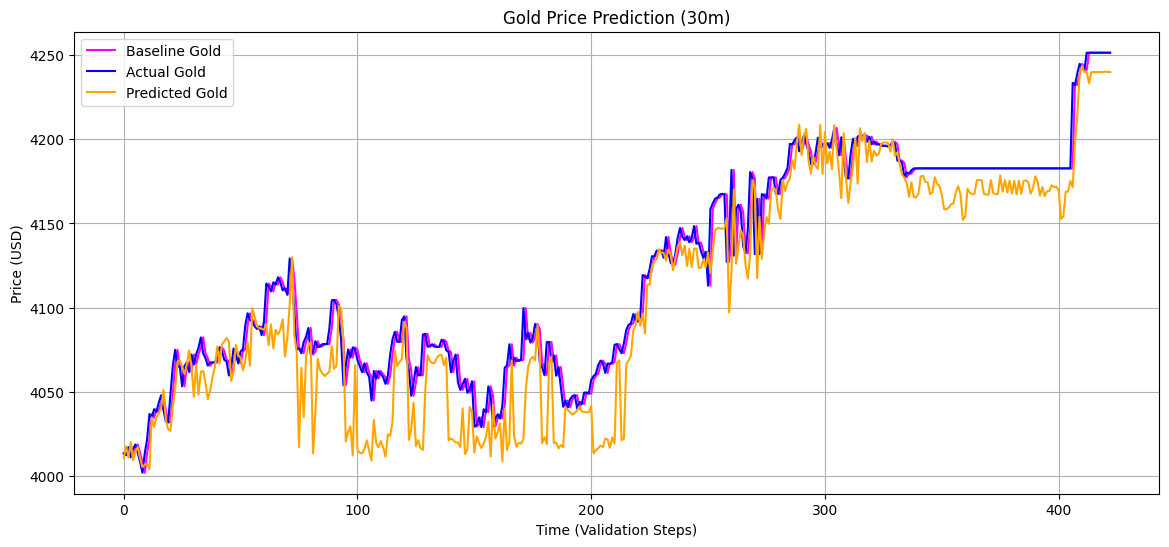

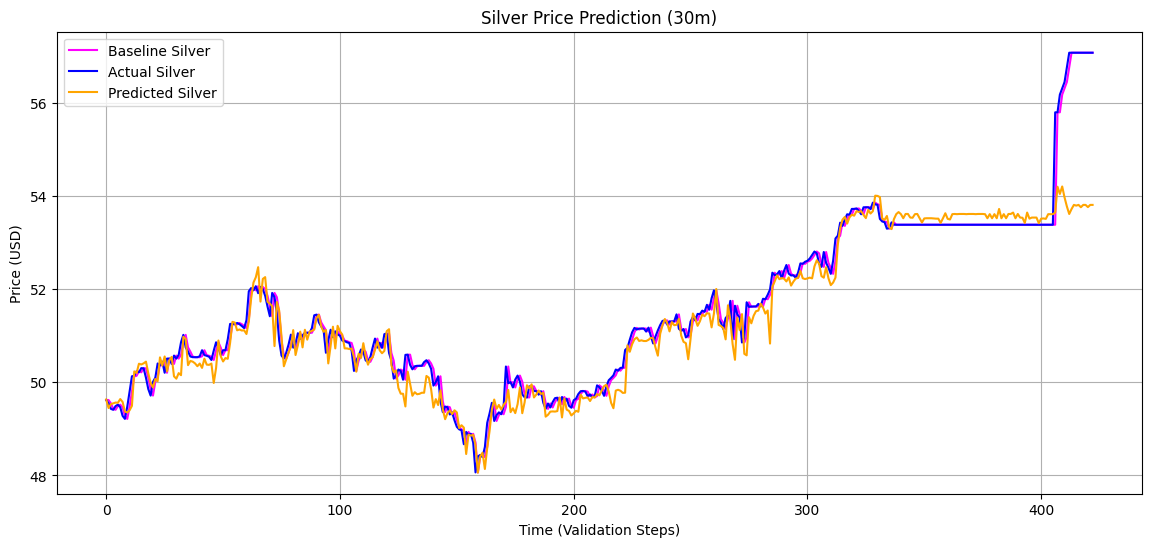

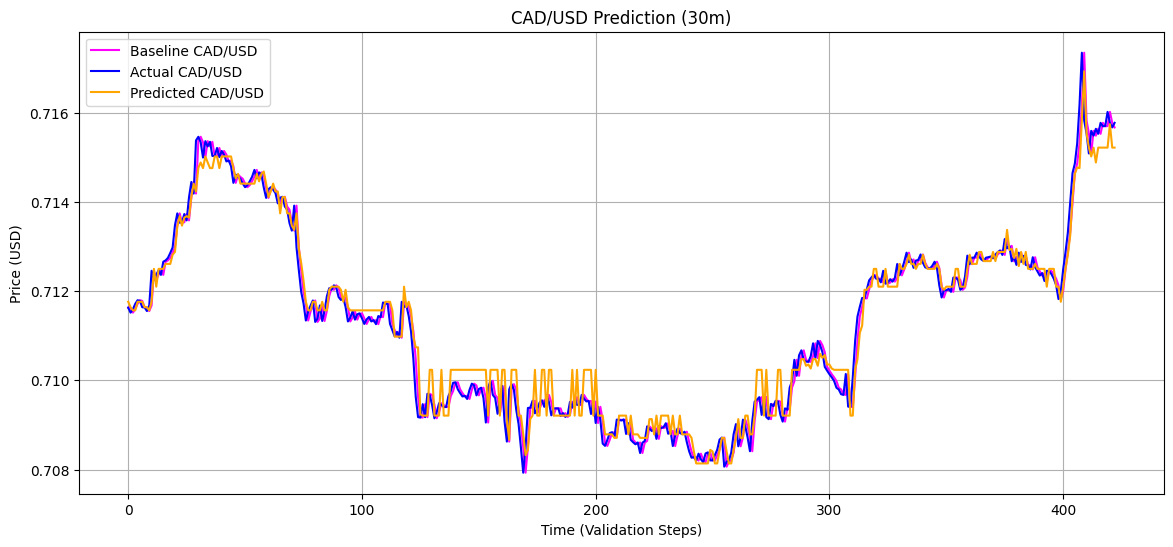

In [143]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (30m)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()